In [2]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

#%tensorflow_version 1.x
import tensorflow as tf
import cv2

2022-07-24 23:27:25.511136: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix , classification_report 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

from keras.models import model_from_json
import cv2, os
from keras.layers import Flatten
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

In [36]:
train_dir = r"dataset/ImageEmotion (85-15)/train"
test_dir = r"dataset/ImageEmotion (85-15)/test"

SEED = 12
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 128
momentum = 0.9
EPOCHS = 500
#FINE_TUNING_EPOCHS = 30
LR = 0.001
NUM_CLASSES = 8
EARLY_STOPPING_CRITERIA=3
CLASS_LABELS  = ['Amusement', 'Anger', 'Awe', 'Contentment', 'Disgust', 'Excitement', 'Fear', 'Sadness']
CLASS_LABELS_EMOJIS = ["🥳", "😡", "😯", "😌", "🤢" ,"🤩", "😱" , "😔" ]

In [37]:
preprocess_fun = tf.keras.applications.mobilenet.preprocess_input

train_datagen = ImageDataGenerator(#horizontal_flip=True,
                                   #width_shift_range=0.1,
                                   #height_shift_range=0.05,
                                   rescale = 1./255,
                                   validation_split = 0,
                                   #preprocessing_function=preprocess_fun
                                  )
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0,
                                  #preprocessing_function=preprocess_fun
                                 )

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = True , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                    seed = 12
                                                   )

validation_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                         target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                         batch_size = BATCH_SIZE,
                                                         shuffle  = True , 
                                                         color_mode = "rgb",
                                                         class_mode = "categorical",
                                                         subset = "validation",
                                                         seed = 12
                                                        )

test_generator = test_datagen.flow_from_directory(directory = test_dir,
                                                   target_size = (IMG_HEIGHT ,IMG_WIDTH),
                                                    batch_size = BATCH_SIZE,
                                                    shuffle  = False , 
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    seed = 12
                                                  )

Found 18559 images belonging to 8 classes.
Found 0 images belonging to 8 classes.
Found 3277 images belonging to 8 classes.


In [13]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""
    
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'
    
    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()

        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                #graph_def = tf.GraphDef.FromString(file_handle.read())
                #graph = tf.Graph()
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()
        
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')
            
        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)
        
    def run(self, image):
        """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
        #width, height = image.shape[0], image.shape[1]
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        #resized_image = np.resize(image, target_size)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        
        return resized_image, seg_map
    
def create_ade20k_label_colormap():
        
    """Creates a label colormap used in ADE20K segmentation benchmark.

  Returns:
    A colormap for visualizing segmentation results.
  """
    colormap = np.asarray([
        [0,0,0],
        [120, 120, 120],
        [180, 120, 120],
        [6, 230, 230],
        [80, 50, 50],
        [4, 200, 3],
        [120, 120, 80],
        [140, 140, 140],
        [204, 5, 255],
        [230, 230, 230],
        [4, 250, 7],
        [224, 5, 255],
        [235, 255, 7],
        [150, 5, 61],
        [120, 120, 70],
        [8, 255, 51],
        [255, 6, 82],
        [143, 255, 140],
        [204, 255, 4],
        [255, 51, 7],
        [204, 70, 3],
        [0, 102, 200],
        [61, 230, 250],
        [255, 6, 51],
        [11, 102, 255],
        [255, 7, 71],
        [255, 9, 224],
        [9, 7, 230],
        [220, 220, 220],
        [255, 9, 92],
        [112, 9, 255],
        [8, 255, 214],
        [7, 255, 224],
        [255, 184, 6],
        [10, 255, 71],
        [255, 41, 10],
        [7, 255, 255],
        [224, 255, 8],
        [102, 8, 255],
        [255, 61, 6],
        [255, 194, 7],
        [255, 122, 8],
        [0, 255, 20],
        [255, 8, 41],
        [255, 5, 153],
        [6, 51, 255],
        [235, 12, 255],
        [160, 150, 20],
        [0, 163, 255],
        [140, 140, 140],
        [250, 10, 15],
        [20, 255, 0],
        [31, 255, 0],
        [255, 31, 0],
        [255, 224, 0],
        [153, 255, 0],
        [0, 0, 255],
        [255, 71, 0],
        [0, 235, 255],
        [0, 173, 255],
        [31, 0, 255],
        [11, 200, 200],
        [255, 82, 0],
        [0, 255, 245],
        [0, 61, 255],
        [0, 255, 112],
        [0, 255, 133],
        [255, 0, 0],
        [255, 163, 0],
        [255, 102, 0],
        [194, 255, 0],
        [0, 143, 255],
        [51, 255, 0],
        [0, 82, 255],
        [0, 255, 41],
        [0, 255, 173],
        [10, 0, 255],
        [173, 255, 0],
        [0, 255, 153],
        [255, 92, 0],
        [255, 0, 255],
        [255, 0, 245],
        [255, 0, 102],
        [255, 173, 0],
        [255, 0, 20],
        [255, 184, 184],
        [0, 31, 255],
        [0, 255, 61],
        [0, 71, 255],
        [255, 0, 204],
        [0, 255, 194],
        [0, 255, 82],
        [0, 10, 255],
        [0, 112, 255],
        [51, 0, 255],
        [0, 194, 255],
        [0, 122, 255],
        [0, 255, 163],
        [255, 153, 0],
        [0, 255, 10],
        [255, 112, 0],
        [143, 255, 0],
        [82, 0, 255],
        [163, 255, 0],
        [255, 235, 0],
        [8, 184, 170],
        [133, 0, 255],
        [0, 255, 92],
        [184, 0, 255],
        [255, 0, 31],
        [0, 184, 255],
        [0, 214, 255],
        [255, 0, 112],
        [92, 255, 0],
        [0, 224, 255],
        [112, 224, 255],
        [70, 184, 160],
        [163, 0, 255],
        [153, 0, 255],
        [71, 255, 0],
        [255, 0, 163],
        [255, 204, 0],
        [255, 0, 143],
        [0, 255, 235],
        [133, 255, 0],
        [255, 0, 235],
        [245, 0, 255],
        [255, 0, 122],
        [255, 245, 0],
        [10, 190, 212],
        [214, 255, 0],
        [0, 204, 255],
        [20, 0, 255],
        [255, 255, 0],
        [0, 153, 255],
        [0, 41, 255],
        [0, 255, 204],
        [41, 0, 255],
        [41, 255, 0],
        [173, 0, 255],
        [0, 245, 255],
        [71, 0, 255],
        [122, 0, 255],
        [0, 255, 184],
        [0, 92, 255],
        [184, 255, 0],
        [0, 133, 255],
        [255, 214, 0],
        [25, 194, 194],
        [102, 255, 0],
        [92, 0, 255],
    ])
    return colormap

def label_to_color_image(label):
        """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the ADE20K color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
        if label.ndim != 2:
            raise ValueError('Expect 2-D input label')
        colormap = create_ade20k_label_colormap()
        
        if np.max(label) >= len(colormap):
            raise ValueError('label value too large.')
            
        return colormap[label]
    
def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1]) #分为 1行4列,

    plt.subplot(grid_spec[0])  # 4个图的第一部分
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
        
        
    ax = plt.subplot(grid_spec[3])
    plt.imshow(
        FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()
        
    size = seg_image.shape[0] * seg_image.shape[1]
    selLABEL_NAMES = np.asarray([
                'tree', 'shrub', 'grass','road','sidewalk','sky','building'
                ])
    ratio_sum = ratio_plant = 0
    ratio_tree = ratio_shrub = ratio_grass = ratio_road = ratio_sidewalk = 0
        
    for m in seg_map.flatten():
        label = LABEL_NAMES[m]
        if label == 'tree':
            ratio_tree = ratio_tree+1
        if label == 'shrub':
            ratio_shrub = ratio_shrub+1
        if label == 'grass':
            ratio_grass = ratio_grass+1  
        if label == 'road':
            ratio_road = ratio_road+1 
        if label == 'sidewalk':
            ratio_sidewalk = ratio_sidewalk+1
                
        for n in selLABEL_NAMES:
            if label == n:
                ratio_sum = ratio_sum + 1
            
    ratio_tree_i = ratio_tree / len(seg_map.flatten())
    ratio_shrub_i = ratio_shrub / len(seg_map.flatten())
    ratio_grass_i = ratio_grass / len(seg_map.flatten())
    ratio_road_i = ratio_road / len(seg_map.flatten()) 
    ratio_sidewalk_i = ratio_sidewalk / len(seg_map.flatten()) 

    ratio_plant_i = (ratio_tree + ratio_shrub + ratio_grass)/ len(seg_map.flatten())
    #ratio_sum_i = ratio_sum / len(seg_map.flatten())
    print('tree合计占比为：',ratio_tree_i)
    print('shrub合计占比为：',ratio_shrub_i)
    print('grass合计占比为：',ratio_grass_i)
    print('road合计占比为：',ratio_road_i)
    print('sidewalk合计占比为：',ratio_sidewalk_i)
    print('plant经过计算植物合计占比为：',ratio_plant_i)
        
    return ratio_tree_i, ratio_shrub_i, ratio_grass_i, ratio_plant_i, ratio_road_i ,ratio_sidewalk_i

LABEL_NAMES = np.asarray([
        'ignore', 'wall', 'building', 'sky', 'floor', 'tree', 'ceiling', 'road', 
         'bed', 'window', 'grass', 'cabinet', 'sidewalk', 'person', 'ground', 'door', 
        'table', 'mount', 'shrub', 'curtain', 'chair', 'car', 'water', 'picture', 
        'couch', 'shelf', 'house', 'sea', 'mirror', 'rug', 'field', 'armchair',
        'seat', 'fence', 'desk', 'rock', 'clothes', 'lamp', 'bath', 'rail', 'cushion',
        'stand', 'box', 'pillar', 'signboard', 'drawers', 'counter', 'sand', 'sink',
        'skyscraper', 'fireplace', 'refrigerator', 'cupboard', 'path', 'steps',
        'runway', 'case', 'pool', 'pillow', 'screen', 'stairway', 'river', 
        'bridge', 'bookcase', 'blinds', 'coffeeTable', 'toilet', 'flower', 'book',
        'hill', 'bench', 'countertop', 'kitchen Sove', 'tree', 'kitchen', 
        'computingMachine', 'chair', 'boat', 'bar', 'machine', 'hut', 'bus', 
        'towel', 'light', 'truck', 'tower', 'chandelier', 'awning', 'streetlight',
        'booth', 'displayMonitor', 'airplane', 'dirtTrack', 'apparel', 'pole', 
        'ground', 'handrail', 'escalator', 'ottoman', 'bottle', 'counter', 'poster', 
        'stage', 'van', 'ship', 'fountain', 'conveyor', 'canopy', 'washer', 'toy', 
        'swimmingPool', 'stool', 'barrel', 'basket', 'waterfall', 'tent', 'bag', 
        'bike', 'cradle', 'oven', 'ball', 'food', 'step', 'container', 'brandLogo', 
        'oven', 'pot', 'animal', 'bicycle', 'lake', 'dishwasher', 'projectorScreen', 
        'blanket', 'statue', 'hood', 'sconce', 'vase', 'trafficLight', 'tray', 
        'GarbageBin', 'fan', 'dock', 'computerMonitor', 'plate', 'monitoringDevice', 
        'bulletinBoard', 'shower', 'radiator', 'drinkingGlass', 'clock', 'flag'
     ])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
#print('FULL_LABEL_MAP',FULL_LABEL_MAP)

FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)
#print('FULL_COLOR_MAP',FULL_COLOR_MAP)

In [42]:
len(LABEL_NAMES)

151

In [14]:
MODEL_NAME = 'xception65_ade20k_train'  # @param ['mobilenetv2_ade20k_train', 'xception65_ade20k_train']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_ade20k_train':
        'deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz',
    'xception65_ade20k_train':
        'deeplabv3_xception_ade20k_train_2018_05_29.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)

# Reduce image size if mobilenet model
if "mobilenetv2" in MODEL_NAME:
    MODEL.INPUT_SIZE = 257

print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [169]:
MODEL.INPUT_SIZE = 420

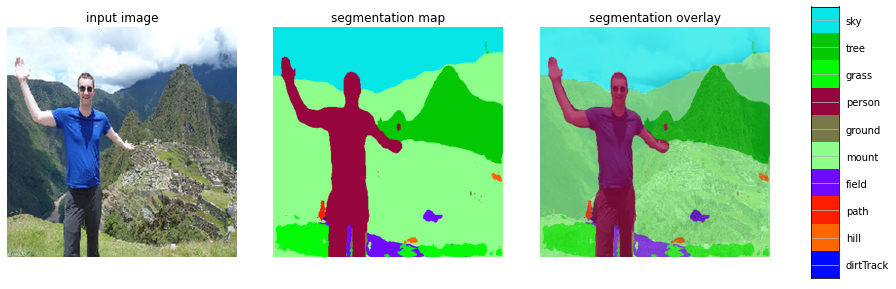

tree合计占比为： 0.11331632653061224
shrub合计占比为： 0.0
grass合计占比为： 0.04757936507936508
road合计占比为： 0.0
sidewalk合计占比为： 0.0
plant经过计算植物合计占比为： 0.16089569160997733


(0.11331632653061224, 0.0, 0.04757936507936508, 0.16089569160997733, 0.0, 0.0)

In [176]:
#from PIL import ImageOps
#img_path = r"dataset/Custom_test/any class/anger_0880-Copy1.jpg"
#img = plt.imread(img_path)
#img.shape
#plt.imshow(img)
#plt.show()
#type(img)
#train_generator[0][0][0].shape
img = train_generator[0][0][15]
#img = np.resize(train_generator[10][0][12], (500,500,3))
img = img*255
img = img.astype(np.uint8)
img = Image.fromarray(img)
#img.size
resized_im, seg_map = MODEL.run(img)
vis_segmentation(resized_im, seg_map)
#img

In [177]:
seg_map.shape

(420, 420)

In [41]:
seg_map

array([[ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5],
       ...,
       [18, 18, 18, ...,  5,  5,  5],
       [ 5, 18, 18, ...,  5,  5,  5],
       [ 5,  5,  5, ...,  5,  5,  5]])

In [25]:
img.shape

(2686, 4029, 3)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x427 at 0x20A492DE340>
running deeplab on image https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/image1.jpg?raw=true...


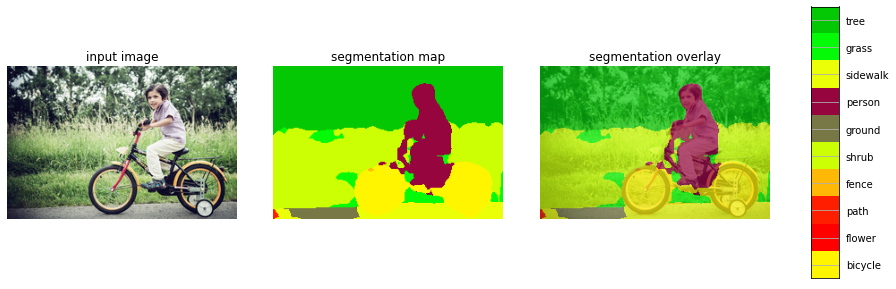

tree合计占比为： 0.36955878672036774
shrub合计占比为： 0.2880970259630919
grass合计占比为： 0.03747696088470203
road合计占比为： 0.0
sidewalk合计占比为： 0.04862675495483196
经过计算植物合计占比为： 0.6951327735681616


In [22]:
SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

def run_visualization(url):
    """Inferences DeepLab model and visualizes result."""
    try:
        f = urllib.request.urlopen(url)
        jpeg_str = f.read()
        original_im = Image.open(BytesIO(jpeg_str))
        print(original_im)
    except IOError:
        print('Cannot retrieve image. Please check url: ' + url)
        return
    
    print('running deeplab on image %s...' % url)
    resized_im, seg_map = MODEL.run(original_im)

    vis_segmentation(resized_im, seg_map)
    
image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)

running deeplab on image https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/img/image3.jpg?raw=true...


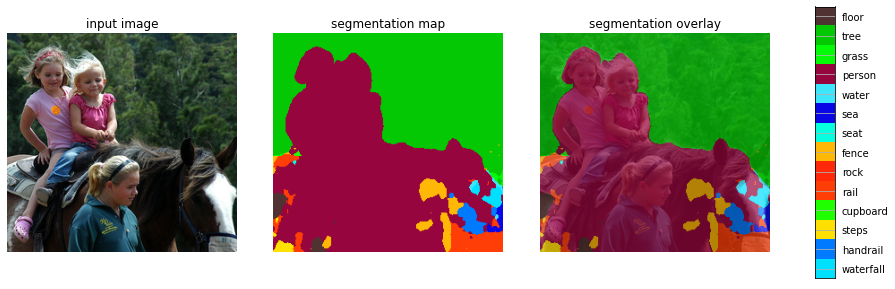

tree合计占比为： 0.3783408815462142
shrub合计占比为： 0.0
grass合计占比为： 0.0017063213625055813
road合计占比为： 0.0
sidewalk合计占比为： 0.0
经过计算植物合计占比为： 0.3800472029087198


In [21]:
SAMPLE_IMAGE = 'image3'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

def run_visualization(url):
    """Inferences DeepLab model and visualizes result."""
    try:
        f = urllib.request.urlopen(url)
        jpeg_str = f.read()
        original_im = Image.open(BytesIO(jpeg_str))
    except IOError:
        print('Cannot retrieve image. Please check url: ' + url)
        return
    
    print('running deeplab on image %s...' % url)
    resized_im, seg_map = MODEL.run(original_im)

    vis_segmentation(resized_im, seg_map)
    
image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)